Isolation Forest algorithm works for both univariate and multivariate datasets, and uses unsupervised learning

This algo is ideal for detecting anomalies when you have multiple input features because of its ability to handle multivariate data. However, we are mostly using univariate data (just our univariate timeseries metrics), but we also exercise the multivariate capabilities when we perform Principle Component Analysis on the whole dataset to see when the repo as a whole is in an anomolous state.

In our case, our input features will be various different metrics provided by our own api.

The goal of this algo is to determine when a particular metric or the whole repo is in an anomalous state. This could mean, for example, that we are detecting a spike in issues opened.

BELOW IS EXTRA INFO THAT EXPLAINS MORE ABOUT THE ALGORITHM IF YOU ARE INTERESTED:

It works similar to Decision trees algorithm, where we start with a root node and keep on partitioning the space. In Isolation forest we partition randomly, unlike Decision trees where the partition is based on information gain.

Partitions are created by randomly selecting a feature and then randomly creating a split value between the maximum and the minimum value of the feature. We keep on creating the partitions until we isolate all the points(in most cases we also set a limit on number of partitions/height of the tree). The anomaly will be detected in smaller number of partitions than a normal point

So clearly the path length indicates whether a point is a normal or an anomalous point. (Path length - of a point x is measured by the number of edges x traverses an Isolation tree from the root node until the traversal is terminated at an external node)

Isolation forest is an ensemble method. So we create multiple Isolation trees(generally 100 trees will suffice) and we take the average of all the path lengths. This average path length will then decide whether a point is anomalous or not.

WHY ISOLATION FOREST?

Advanced outlier detection methods such as Isolation Forests are imperative for companies looking to reduce fraud because this method detects anomalies purely based on the concept of isolation without employing any distance or density measure —fundamentally different from all existing methods.

As a result, Isolation Forests are able to exploit subsampling to achieve a low linear time-complexity and a small memory-requirement, and to deal with the effects of swamping and masking effectively.

In [26]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

In [27]:
import pandas as pd
import requests
import datetime
import json

# Declare method for collecting data
def collect_data():
    # this part will be in config or provided by broker in implementation
    training_days = 365
    repo_id = 21000
    
    # Declare the endpoints we want to discover insights for in the format ({*endpoint*: *field*})
    endpoints = [{'issues-new': 'issues'}, {'code-changes': 'commit_count'}, {'code-changes-lines': 'added'}, 
                   {'reviews': 'pull_requests'}, {'contributors-new': 'new_contributors'}]
    
    augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='../augur.config.json')
    augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='../augur.config.json')
    base_url = 'http://{}:{}/api/unstable/repo-groups/9999/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)
    
    # Dataframe to hold all endpoint results
    # Subtract configurable amount of time
    begin_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
#   begin_date = begin_date.strftime('%Y-%m-%d')
    index = pd.date_range(begin_date, periods=training_days, freq='D')
    df = pd.DataFrame(index=index)#, columns=[key for d in endpoints for key in d.keys()])
    
    # Hit and discover insights for every endpoint we care about
    for metric_meta in endpoints:
        for endpoint, field in metric_meta.items():
            # Hit endpoint
            url = base_url + endpoint
            print("Hitting endpoint: " + url + "\n")
#             try:
            data = requests.get(url=url).json()
#             except:
#                 data = json.loads(json.dumps(requests.get(url=url).text))

            if len(data) == 0:
                print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
                continue
                
            if 'date' not in data[0]:
                print("Endpoint {} is not a timeseries, moving to next endpoint.".format(endpoint))
                continue
            
            metric_df = pd.DataFrame.from_records(data)
            metric_df.index = pd.to_datetime(metric_df['date'], utc=True).dt.date
#             print(metric_df)
#             df.add(metric_df[field])
#             df = pd.concat(df, metric_df[field])
            df = df.join(metric_df[field]).fillna(0)
#             print(df)
        
    return df
df = collect_data()
df

Hitting endpoint: http://0.0.0.0:5002/api/unstable/repo-groups/9999/repos/21000/issues-new

Hitting endpoint: http://0.0.0.0:5002/api/unstable/repo-groups/9999/repos/21000/code-changes

Hitting endpoint: http://0.0.0.0:5002/api/unstable/repo-groups/9999/repos/21000/code-changes-lines

Hitting endpoint: http://0.0.0.0:5002/api/unstable/repo-groups/9999/repos/21000/reviews

Hitting endpoint: http://0.0.0.0:5002/api/unstable/repo-groups/9999/repos/21000/contributors-new



,issues,commit_count,added,pull_requests,new_contributors
2019-03-03,0.0,90.0,45.0,0.0,0.0
2019-03-04,2.0,0.0,64.0,0.0,1.0
2019-03-05,1.0,0.0,1108.0,0.0,0.0
2019-03-06,2.0,0.0,151.0,0.0,1.0
2019-03-07,0.0,0.0,97.0,0.0,0.0
2019-03-08,1.0,0.0,6943.0,0.0,0.0
2019-03-09,0.0,0.0,634.0,0.0,0.0
2019-03-10,0.0,117.0,105.0,0.0,0.0
2019-03-11,1.0,0.0,200.0,0.0,1.0
2019-03-12,1.0,0.0,96.0,0.0,1.0


In [62]:
import pandas as pd
import json
import requests
url = 'http://localhost:5002/api/unstable/repo-groups/20/repos/21000/code-changes'
data = requests.get(url=url).json()

In [67]:
# data = pd.DataFrame.from_records(data)
# data['week'] = data['week'].apply(lambda x: x - 1)
data['date'] = data['year'].astype(str) + ' ' + data['week'].astype(str) + ' 0'
data

,commit_count,date,repo_name,week,year
0,86.0,2019 0 0,rails,0,2019
1,75.0,2019 1 0,rails,1,2019
2,135.0,2019 2 0,rails,2,2019
3,84.0,2019 3 0,rails,3,2019
4,95.0,2019 4 0,rails,4,2019
5,101.0,2019 5 0,rails,5,2019
6,109.0,2019 6 0,rails,6,2019
7,101.0,2019 7 0,rails,7,2019
8,90.0,2019 8 0,rails,8,2019
9,117.0,2019 9 0,rails,9,2019


In [66]:
import datetime, math
# cols = ['year', 'week']
# data['date'] = pd.to_datetime(datetime.datetime(data['year'], math.ceil(data['week'] / 52 * 12), data['week'] * 7 - 7))
data['date'] = data['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y %W %w"))

# data['datef'] = data.apply(lambda x: print('{}/{}/{}'.format(x['year'], math.ceil(x['week'] / 52 * 12) if math.ceil(x[2] / 52 * 12) <= 12 else 12, int(x[2] % 4 * 7))))
data

,commit_count,date,repo_name,week,year
0,86.0,2019-01-01,rails,0,2019
1,75.0,2019-01-08,rails,1,2019
2,135.0,2019-01-15,rails,2,2019
3,84.0,2019-01-22,rails,3,2019
4,95.0,2019-01-29,rails,4,2019
5,101.0,2019-02-05,rails,5,2019
6,109.0,2019-02-12,rails,6,2019
7,101.0,2019-02-19,rails,7,2019
8,90.0,2019-02-26,rails,8,2019
9,117.0,2019-03-05,rails,9,2019


Visualize all our metrics before doing anomaly detection

In [3]:
# df.plot(y=['issues'], kind='line')
df.plot(y=['commit_count'], kind='line')
# df.plot(y=['pull_requests'], kind='line')
df.plot(y=['added'], kind='line')
# df.plot(y=['new_contributors'], kind='line')
#             {
#                 "model": "insights",
#                 "given": ["git_url"],
#                 "delay": 150000,
#                 "repo_group_id": 0
#             }

Isolation forest tries to separate each point in the data. In case of 2D data it randomly creates a line and tries to single out a point. Here an anomalous point could be separated in a few steps while normal points which are closer could take significantly more steps to be segregated.

I am using sklearn’s Isolation Forest here as it is a small dataset with 1 year of data, worth noting h2o’s isolation forest is a potentially more scalable possibility on high volume datasets, if the amount of data starts to impact sklearn's performace

Contamination is an important parameter here. It is the assumption of the percentage of outlier points in the data. Through testing I found 0.041 to be a fitting value for our use case (which will give us around 15 anomalies / year per metric). 

THIS CAN AND SHOULD BE TWEAKED THOUGH:

15-30 anomalies a year makes sense for rails/rails but not so much for smaller repos where there is only 15 commits / year, we don't want EVERY action to be considered anomalous. A table of updated contamination values could help control something like this, provide flexibility for different repos, and allow a possibility to make this algorithm's implementation semi-supervised (maybe with questions in the slack bot: Would you consider this anomaly that you were just notified about a TRUE anomaly? [yes / no]) if yes -> do nothing, if no -> lower the contamination value for this repo slightly. Or another question: did any events occur in your repository that YOU would consider anomalous that our slack bot did not notify you about? if yes -> increase contamination parameter

In [4]:
from sklearn.ensemble import IsolationForest

# specify the 4 metric names that we will model
to_model_columns = df.columns[0:5]

model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.041), 
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=32, verbose=0)
model.fit(df[to_model_columns])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.041,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=32, verbose=0, warm_start=False)

In [5]:
import numpy as np
pred = model.predict(df[to_model_columns])
df['anomaly'] = pred
outliers = df.loc[df['anomaly'] == -1]
outlier_index = list(outliers.index)

# Find the number of anomalies and normal points here points classified -1 are anomalous
print(df['anomaly'].value_counts())
boolean_anomalies = df['anomaly'].where(df['anomaly'] == -1, False).where(df['anomaly'] != -1, True).values
boolean_anomalies = boolean_anomalies.astype(np.bool_)

 1    350
-1     15
Name: anomaly, dtype: int64


Now we have 4 metrics on which we have classified anomalies based on isolation forest. We will try to visualize the results and check if the classification makes sense.

We will now normalize and fit the metrics to a PCA to reduce the number of dimensions and then plot them in 3D highlighting the anomalies.

This chart below is very conceptual as it is plotting anomalies for the repo as a whole, and our repo is then reduced to 3 defining fields (which do NOT map to any specific metric, but are rather entirely "new" parameters that define the whole repo) which are the parameters that make up the x, y, and x axes.

Anomalies are red X's and normal points are indicated with green points in the plot.

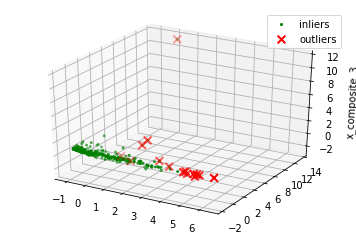

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()

# normalize the metrics
X = scaler.fit_transform(df[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3") # Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")# Plot x's for the ground truth outliers
ax.scatter(X_reduce[boolean_anomalies, 0],X_reduce[boolean_anomalies, 1], X_reduce[boolean_anomalies, 2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

Now as 2D

Anomalies are highlighted as red edges and normal points are indicated with green points in the plot.

Here the contamination parameter plays a great factor.

Another conceptual chart that helps see anomalies across the whole repo as well, but also helps in the parameter-tuning process, specifically for the contamination parameter.

Our idea here is to capture all the anomalous point in the system. So its better to identify few points which might be normal as anomalous (false positives), but not to miss out catching an anomaly (true negative). (So I have specified 4.1% as contamination which varies based on use case and repo)

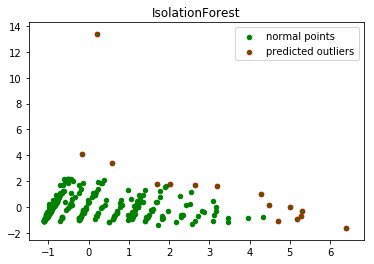

In [7]:
pca = PCA(n_components=2)
scaler = StandardScaler()

# normalize the metrics
X = scaler.fit_transform(df[to_model_columns])
X_reduce = pca.fit_transform(X)

# pca.fit(df[to_model_columns])
# res = pd.DataFrame(pca.transform(df[to_model_columns]))
# Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf(Z, cmap=plt.cm.Blues_r)
# b1 = plt.scatter(res[0], res[1], c='green', s=20, label="normal points")
# b1 = plt.scatter(res.iloc[boolean_anomalies,0], res.iloc[boolean_anomalies,1], c='green', s=20, edgecolor="red", label="predicted outliers")
b1 = plt.scatter(X_reduce[:, 0], X_reduce[:, 1], c='green', s=20, label="normal points")
b1 = plt.scatter(X_reduce[boolean_anomalies, 0], X_reduce[boolean_anomalies, 1], c='green', s=20, edgecolor="red", label="predicted outliers")

plt.legend(loc="upper right")
plt.show()

Now we have figured the anomalous behavior at a use case level, but to be actionable on the anomaly its important to identify and provide information on which specific metrics are anomalous individually.

The anomalies identified by the algorithm should make sense when viewed visually (sudden dip/peaks) by the business user to act upon it. So creating a good visualization is equally important in this process.

The following function creates actuals plot on a time series with anomaly points highlighted on it. Also a table which provides actual data, the change and conditional formatting based on anomalies.

In [8]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
from matplotlib import pyplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

def plot_anomaly(df,field_name):
    df.date = pd.to_datetime(df['date_col'].astype(str))#, format="%Y%m%d")
    dates = df.date
    
    # Identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    metric_value = df[field_name][-len(bool_array):]
    anomaly_points = bool_array * metric_value
    anomaly_points[anomaly_points == 0] = np.nan
    
    med_bool_array = (abs(test_df['anomaly_class']) == 1)
    med_metric_value = df[field_name][-len(med_bool_array):]
    med_anomaly_points = med_bool_array * med_metric_value
    med_anomaly_points[med_anomaly_points == 0] = np.nan    
    
    # A dictionary for conditional format table based on anomaly
    color_map = {0: "rgba(228, 222, 249, 0.65)", 1: "yellow", 2: "red"} #rgba(228, 222, 249, 0.65)
    
    # Table which includes Date, Actuals, Change occured from previous point
    table = go.Table(
        domain = dict(x = [0, 1], y = [0, 0.3]),
        columnwidth = [1, 2],
        # columnorder=[0, 1, 2,],
        header = dict(
            height=20,
            values=[['<b>Date</b>'], ['<b>Metric Value </b>'], ['<b>% Change </b>'],],
            font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
            fill=dict(color='#d562be')
        ),
        cells = dict(
            values = [df.round(3)[k].tolist() for k in ['date_col', field_name, 'percentage_change']],
            line = dict(color='#506784'),
            align = ['center'] * 5,
            font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
            # format = [None] + [",.4f"] + [',.4f'],
            # suffix = [None] * 4,
            suffix = [None] + [''] + [''] + ['%'] + [''],
            height = 27,
            fill = dict(color = [test_df['anomaly_class'].map(color_map)],)#map based on anomaly level from dictionary
        )
    )
    
    #Plot the actuals points
    metric = go.Scatter(
        name = 'Metric Value',
        x = dates,
        y = df[field_name],
        xaxis = 'x1', 
        yaxis = 'y1',
        mode = 'lines',
        marker = dict(
            size = 12,
            line = dict(width=1),
            color = "blue")
        ) #Highlight the anomaly points
    anomalies_map = go.Scatter(
        name = "Anomaly",
        showlegend = True,
        x = dates,
        y = anomaly_points,
        mode = 'markers',
        xaxis = 'x1',
        yaxis = 'y1',
        marker = dict(
            color = "red",
            size = 11,
            line = dict(
                color = "red",
                width = 2)
            )
        )
    med_anomalies_map = go.Scatter(
        name = "Light Anomaly",
        showlegend = True,
        x = dates,
        y = med_anomaly_points,
        mode = 'markers',
        xaxis = 'x1',
        yaxis = 'y1',
        marker = dict(
            color = "yellow",
            size = 11,
            line = dict(
                color = "yellow",
                width = 2)
            )
    )
    axis = dict(
        showline = True,
        zeroline = False,
        showgrid = True,
        mirror = True,
        ticklen = 4,
        gridcolor = '#ffffff',
        tickfont = dict(size=10)
    )
    layout = dict(
        width = 1000,
        height = 865,
        autosize = False,
        title = field_name,
        margin = dict(t = 75),
        showlegend = True,
        xaxis1 = dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1 = dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f'))
    )
    fig = go.Figure(data=[table, anomalies_map, med_anomalies_map, metric], layout=layout)
    iplot(fig)
pyplot.show()

A helper function to find percentage change,classify anomaly based on severity.

The predict function classifies the data as anomalies based on the results from decision function on crossing a threshold. Say if the business needs to find the next level of anomalies which might have an impact, this could be used to identify those points.

The top 12 quantiles are identified anomalies(high severity), based on decision function here we identify the 12–24 quantile points and classify them as low severity anomalies.

In [9]:
def classify_anomalies(df,field_name):
#     df[field_name] = metric_name
    df = df.sort_values(by='date_col', ascending=False)
    
    # Shift metric values by one date to find the percentage chage between current and previous data point
    df['shift'] = df[field_name].shift(-1)
    df['percentage_change'] = ((df[field_name] - df['shift']) / df[field_name]) * 100
    
    # Categorise anomalies as 0 - no anomaly, 1 - low anomaly , 2 - high anomaly
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    return df

Identify anomalies for individual metrics and plot the results.

X axis — date Y axis — Metric values and anomaly points.

The plots allow us to see the sudden spikes and dips in the metric's value and project the anomalous points onto the plot.

The tables below each plot allow us to examine the raw data and see potential holes or broken pipelines in the data that would need to be fixed in our preprocessing steps. They also let us see which anomalies are low-level (yellow) or high level (red)

In [11]:
import warnings
warnings.filterwarnings('ignore')
for i, field_name in enumerate(to_model_columns):
    print("NEW, metric: {}".format(field_name))
    model.fit(df.iloc[:,i:i+1])
    pred = model.predict(df.iloc[:,i:i+1])
    test_df = pd.DataFrame()
    
    test_df['date_col'] = df.index#df['date']
    test_df.index = df.index
    
    # Find decision function to find the score and classify anomalies
    test_df['score'] = model.decision_function(df.iloc[:,i:i+1])
    test_df[field_name] = df.iloc[:,i:i+1]
    test_df['anomaly'] = pred

    # Get the indexes of outliers in order to compare the metrics with use case anomalies if required
    outliers = test_df.loc[test_df['anomaly'] == -1]
    outlier_index = list(outliers.index)
    test_df = classify_anomalies(test_df,field_name)
    
    # Filter the anomaly_df by days we want to detect anomalies
    begin_detection_date = datetime.datetime.now() - datetime.timedelta(days=180)
    detection_tuples = test_df.index > begin_detection_date
    test_df = test_df.loc[detection_tuples]
    
    plot_anomaly(test_df,field_name)
    
    if test_df.loc[test_df['anomaly_class'] == 2].empty:
        print("No more anomalies to be found")
        continue
#     test_df['anomaly_class'] = pd.to_numeric(test_df['anomaly_class'])
    most_recent_anomaly_date = test_df.loc[test_df['anomaly_class'] == 2]['anomaly_class'].idxmax()
    print("most recent date")
    print(most_recent_anomaly_date)
    most_recent_anomaly = test_df.loc[test_df.index == most_recent_anomaly_date]
    print("MOST RECENT: {}".format(most_recent_anomaly))
    
    display(test_df.head(100))
    
    

NEW, metric: issues


,date_col,score,issues,anomaly,shift,percentage_change,anomaly_class
2020-02-07,2020-02-07,0.15776,0.0,0,0.0,NaN,0
2020-02-06,2020-02-06,0.15776,0.0,0,0.0,NaN,0
2020-02-05,2020-02-05,0.15776,0.0,0,0.0,NaN,0
2020-02-04,2020-02-04,0.15776,0.0,0,0.0,NaN,0
2020-02-03,2020-02-03,0.15776,0.0,0,0.0,NaN,0
2020-02-02,2020-02-02,0.15776,0.0,0,0.0,NaN,0
2020-02-01,2020-02-01,0.15776,0.0,0,0.0,NaN,0
2020-01-31,2020-01-31,0.15776,0.0,0,0.0,NaN,0
2020-01-30,2020-01-30,0.15776,0.0,0,0.0,NaN,0
2020-01-29,2020-01-29,0.15776,0.0,0,0.0,NaN,0


most recent date
2019-10-30 00:00:00
MOST RECENT:              date_col     score  issues  anomaly  shift  percentage_change  \
2019-10-30 2019-10-30 -0.115051     8.0        2    2.0               75.0   

            anomaly_class  
2019-10-30              2  
NEW, metric: commit_count


most recent date
2019-12-18 00:00:00
MOST RECENT:              date_col     score  commit_count  anomaly  shift  \
2019-12-18 2019-12-18 -0.097129          34.0        2   46.0   

            percentage_change  anomaly_class  
2019-12-18         -35.294118              2  


,date_col,score,commit_count,anomaly,shift,percentage_change,anomaly_class
2020-02-07,2020-02-07,0.008892,0.0,0,0.0,NaN,1
2020-02-06,2020-02-06,0.008892,0.0,0,0.0,NaN,1
2020-02-05,2020-02-05,0.008892,0.0,0,0.0,NaN,1
2020-02-04,2020-02-04,0.008892,0.0,0,0.0,NaN,1
2020-02-03,2020-02-03,0.008892,0.0,0,0.0,NaN,1
2020-02-02,2020-02-02,0.008892,0.0,0,0.0,NaN,1
2020-02-01,2020-02-01,0.008892,0.0,0,0.0,NaN,1
2020-01-31,2020-01-31,0.008892,0.0,0,0.0,NaN,1
2020-01-30,2020-01-30,0.008892,0.0,0,0.0,NaN,1
2020-01-29,2020-01-29,0.008892,0.0,0,4.0,-inf,1


NEW, metric: added


most recent date
2019-12-17 00:00:00
MOST RECENT:              date_col    score  added  anomaly  shift  percentage_change  \
2019-12-17 2019-12-17 -0.05105  606.0        2  158.0          73.927393   

            anomaly_class  
2019-12-17              2  


,date_col,score,added,anomaly,shift,percentage_change,anomaly_class
2020-02-07,2020-02-07,0.137146,0.0,0,0.0,NaN,0
2020-02-06,2020-02-06,0.137146,0.0,0,0.0,NaN,0
2020-02-05,2020-02-05,0.137146,0.0,0,0.0,NaN,0
2020-02-04,2020-02-04,0.137146,0.0,0,0.0,NaN,0
2020-02-03,2020-02-03,0.137146,0.0,0,0.0,NaN,0
2020-02-02,2020-02-02,0.137146,0.0,0,0.0,NaN,0
2020-02-01,2020-02-01,0.137146,0.0,0,0.0,NaN,0
2020-01-31,2020-01-31,0.137146,0.0,0,0.0,NaN,0
2020-01-30,2020-01-30,0.137146,0.0,0,0.0,NaN,0
2020-01-29,2020-01-29,0.137146,0.0,0,0.0,NaN,0


NEW, metric: pull_requests


No more anomalies to be found
NEW, metric: new_contributors


most recent date
2019-10-30 00:00:00
MOST RECENT:              date_col     score  new_contributors  anomaly  shift  \
2019-10-30 2019-10-30 -0.132371               7.0        2    1.0   

            percentage_change  anomaly_class  
2019-10-30          85.714286              2  


,date_col,score,new_contributors,anomaly,shift,percentage_change,anomaly_class
2020-02-07,2020-02-07,0.138411,0.0,0,0.0,NaN,0
2020-02-06,2020-02-06,0.138411,0.0,0,0.0,NaN,0
2020-02-05,2020-02-05,0.138411,0.0,0,0.0,NaN,0
2020-02-04,2020-02-04,0.138411,0.0,0,0.0,NaN,0
2020-02-03,2020-02-03,0.138411,0.0,0,0.0,NaN,0
2020-02-02,2020-02-02,0.138411,0.0,0,0.0,NaN,0
2020-02-01,2020-02-01,0.138411,0.0,0,0.0,NaN,0
2020-01-31,2020-01-31,0.138411,0.0,0,0.0,NaN,0
2020-01-30,2020-01-30,0.138411,0.0,0,0.0,NaN,0
2020-01-29,2020-01-29,0.138411,0.0,0,0.0,NaN,0


Things to do next:
- map PCA results over time (ie show WHEN the repo AS A WHOLE is in an anomalous state)
- appeal to a "detection period" (ie still train over whole year but only show anomalies in past x days)
- other ideas I can't remember right now